### Initial read of the data
Creats Y labels based on if that subject_id has an admission after the current charttime

In [5]:
import pandas as pd
import os

#read
folder_name = "alldata/note"
file_name = "discharge.csv"
file_path = os.path.join(os.getcwd(), folder_name, file_name)
df = pd.read_csv(file_path)
df.head(1)

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text
0,10000032-DS-21,10000032,22595853,DS,21,2180-05-07 00:00:00,2180-05-09 15:26:00,\nName: ___ Unit No: _...


In [2]:
#create Y label
df['charttime'] = pd.to_datetime(df['charttime'])
df = df.sort_values(by=['subject_id', 'charttime'])
df['Y'] = df.groupby('subject_id')['charttime'].shift(-1).notna().astype(int)
df.head(1)

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text,Y
0,10000032-DS-21,10000032,22595853,DS,21,2180-05-07,2180-05-09 15:26:00,\nName: ___ Unit No: _...,1


   Readmitted (Y=1)  Not Readmitted (Y=0)
0             60308                 85606


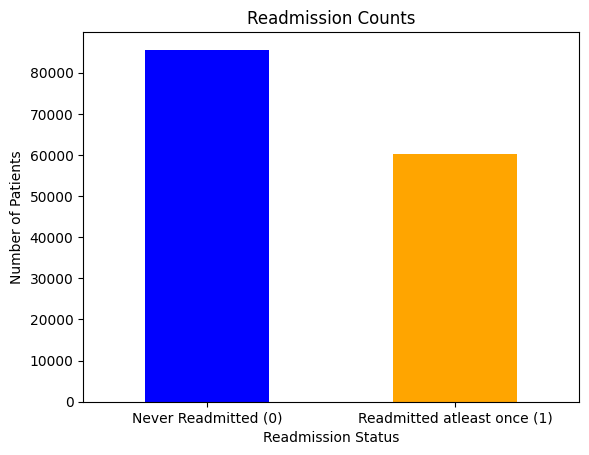

In [3]:
import matplotlib.pyplot as plt

#Count the number of unique subject IDs with at least one readmission (Y=1) and without (Y=0)
readmission_counts = df.groupby('subject_id')['Y'].max().value_counts()

summary_df = pd.DataFrame({
    "Readmitted (Y=1)": [readmission_counts.get(1, 0)],
    "Not Readmitted (Y=0)": [readmission_counts.get(0, 0)]
})

print(summary_df)

readmission_counts.plot(kind='bar', color=['blue', 'orange'])
plt.xlabel('Readmission Status')
plt.ylabel('Number of Patients')
plt.title('Readmission Counts')
plt.xticks(ticks=[0, 1], labels=['Never Readmitted (0)', 'Readmitted atleast once (1)'], rotation=0)
plt.show()


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 331793 entries, 0 to 331792
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   note_id     331793 non-null  object        
 1   subject_id  331793 non-null  int64         
 2   hadm_id     331793 non-null  int64         
 3   note_type   331793 non-null  object        
 4   note_seq    331793 non-null  int64         
 5   charttime   331793 non-null  datetime64[ns]
 6   storetime   331776 non-null  object        
 7   text        331793 non-null  object        
 8   Y           331793 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 25.3+ MB
None


In [4]:
from transformers import pipeline
import torch

device = torch.device("cpu")  # Force CPU
from transformers import pipeline
t5_model = pipeline("summarization", model="t5-small", device=-1)  # -1 means CPU


Device set to use cpu


### Sample 10k rows only

In [12]:
# Randomly sample 10 rows from the dataset for reproducibility
sampled_df = df.sample(n=10000, random_state=42).reset_index(drop=True)

### Vectorize based on hardcoded keywords

#### One-Hot

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

# Define the topics and their associated keywords
topics = {
    "Heart Surgery": ["chest", "artery", "aortic", "cardiac", "ventricular", "coronary", "mitral", "surgery", "heart", "intact", "allergies", "stenosis", "surgical", "systolic", "atrial"],
    "Substance Abuse and Infection": ["urine", "alcohol", "allergies", "acute", "capsule", "infection", "edema", "overdose", "disposition", "withdrawal", "fever", "diagnosis"],
    "Liver Disease": ["liver", "bleeding", "abdominal", "bowel", "cirrhosis", "capsule", "egd", "bleed", "tube", "glucose", "fluid", "chest", "portal", "hepatic", "varices", "abdomen", "ascites", "acute"],
    "Respiratory Conditions": ["respiratory", "pulmonary", "bronchoscopy", "chest", "lung", "pneumonia", "breath", "copd", "capsule", "tube", "cough", "inhalation", "prednisone", "albuterol", "cxr", "lobe", "failure", "chronic", "tracheal"],
    "Kidney Disease": ["renal", "dialysis", "urine", "kidney", "catheter", "capsule", "hemodialysis", "failure", "fluid", "acute", "glucose", "esrd", "infection", "calcium", "chest", "chronic", "insulin"],
    "Biliary Tract Disorders": ["biliary", "pancreatitis", "bile", "abdominal", "stent", "fluid", "gallbladder", "cholangitis", "pancreatic", "acute", "liver", "cbd", "ast", "alt", "lipase", "tube", "abdomen", "drain", "capsule", "glucose"],
    "Diabetes Management": ["insulin", "glucose", "diabetes", "diabetic", "humalog", "lantus", "sugars", "anion", "nausea", "subcutaneous", "capsule", "acute", "calcium", "renal", "unitml", "hyperglycemia", "sugar", "hco", "regimen"],
    "Neurological Disorders": ["seizure", "seizures", "eeg", "dilantin", "keppra", "head", "neurology", "ativan", "intubated", "urine", "bilaterally", "generalized", "mental", "capsule", "alcohol", "glucose", "impression", "further"],
    "Cancer Treatment": ["lymphoma", "melanoma", "metastatic", "mass", "renal", "cell", "chemotherapy", "chest", "edema", "capsule", "brain", "pulmonary", "treatment", "cancer", "mri", "acute", "biopsy", "received", "calcium"],
    "Hand Surgery": ["finger", "hand", "amputation", "repair", "ring", "radial", "injury", "wrist", "long", "plastic", "capsule", "distal", "surgery", "postoperatively", "signs", "proximal", "clinic", "laceration", "dilaudid", "vital"]
}

# Create a set of all keywords from all topics (duplicates are removed)
all_keywords = set()
for kw_list in topics.values():
    all_keywords.update(kw_list)
    
# Convert the set to a sorted list (sorting is optional but ensures consistent column order)
all_keywords = sorted(list(all_keywords))

# Create a CountVectorizer that uses the fixed vocabulary from your keywords
vectorizer = CountVectorizer(vocabulary=all_keywords)

# Apply the vectorizer to the 'text' column of your sampled DataFrame.
# This will count the occurrences of each keyword in each document.
keyword_matrix = vectorizer.fit_transform(sampled_df['text'])

# Convert the resulting sparse matrix into a DataFrame with the keyword names as columns
keyword_features = pd.DataFrame(keyword_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Combine the target variable "Y" with the keyword features.
final_df = pd.concat([sampled_df[['Y']].reset_index(drop=True), keyword_features], axis=1)

print(final_df)


import os
save_path = os.path.join("alldata/note", "final_df.csv")
final_df.to_csv(save_path, index=False)


      Y  abdomen  abdominal  acute  albuterol  alcohol  allergies  alt  \
0     1        1          6      1          0        1          1    2   
1     1        1          2      6          3        0          1    0   
2     0        1          0      0          0        0          1    0   
3     1        0          2      0          0        3          2    0   
4     0        1          1      0          0        1          2    2   
...  ..      ...        ...    ...        ...      ...        ...  ...   
9995  1        0          1      6          0        0          2    2   
9996  0        0          1      1          0        2          2    0   
9997  1        3          1      7          3        0          1    1   
9998  0        2          2      0          0        0          2    0   
9999  0        1          0      0          0        0          2    0   

      amputation  anion  ...  tracheal  treatment  tube  unitml  urine  \
0              0      0  ...         

#### Multi-Hot

In [16]:
# Create a CountVectorizer that uses the fixed vocabulary from your keywords
vectorizerOH = CountVectorizer(vocabulary=all_keywords, binary=True) 

# Apply the vectorizer to the 'text' column of your sampled DataFrame.
# This will count the occurrences of each keyword in each document.
keyword_matrixOH = vectorizerOH.fit_transform(sampled_df['text'])

# Convert the resulting sparse matrix into a DataFrame with the keyword names as columns
keyword_featuresOH = pd.DataFrame(keyword_matrixOH.toarray(), columns=vectorizerOH.get_feature_names_out())

# Combine the target variable "Y" with the keyword features.
final_dfOH = pd.concat([sampled_df[['Y']].reset_index(drop=True), keyword_featuresOH], axis=1)

print(final_dfOH)

save_path = os.path.join("alldata/note", "final_dfOH.csv")
final_dfOH.to_csv(save_path, index=False)

      Y  abdomen  abdominal  acute  albuterol  alcohol  allergies  alt  \
0     1        1          1      1          0        1          1    1   
1     1        1          1      1          1        0          1    0   
2     0        1          0      0          0        0          1    0   
3     1        0          1      0          0        1          1    0   
4     0        1          1      0          0        1          1    1   
...  ..      ...        ...    ...        ...      ...        ...  ...   
9995  1        0          1      1          0        0          1    1   
9996  0        0          1      1          0        1          1    0   
9997  1        1          1      1          1        0          1    1   
9998  0        1          1      0          0        0          1    0   
9999  0        1          0      0          0        0          1    0   

      amputation  anion  ...  tracheal  treatment  tube  unitml  urine  \
0              0      0  ...         

### Plots for one-hot and multi-hot 

/var/folders/67/rsds3lxj78x4092pycb6cnkh0000gn/T/ipykernel_63474/4079458117.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_keywords.index, y=top_keywords.values, palette="viridis")


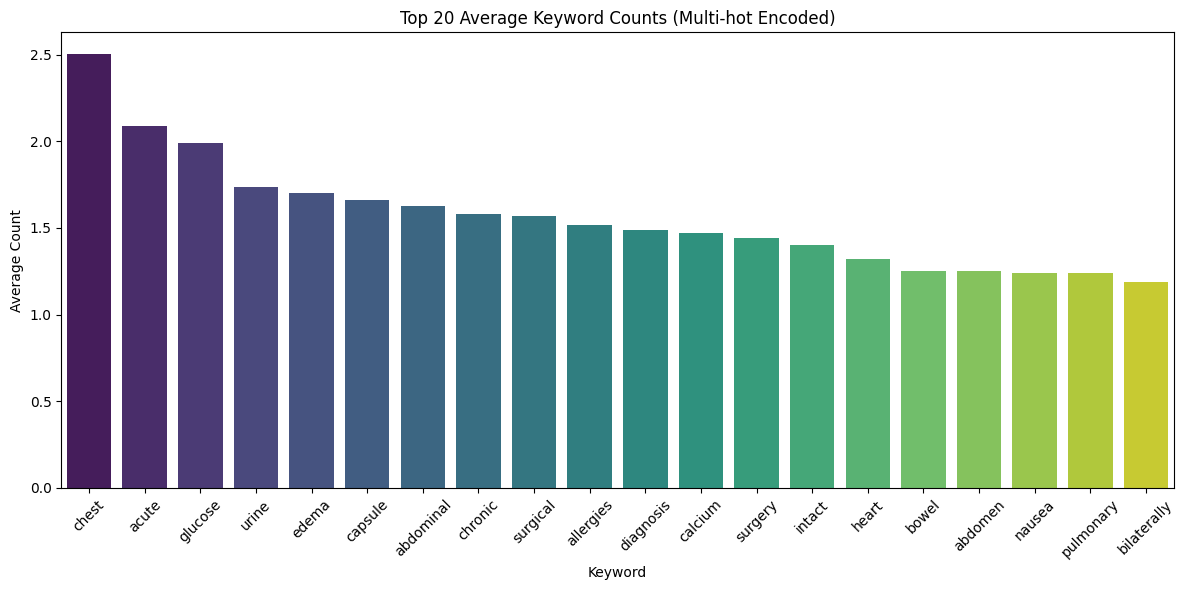

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# For final_df (multi-hot encoded) assume multi_keyword_cols contains all keyword columns.
multi_keyword_cols = final_df.columns.drop("Y")

# Calculate average counts for each keyword.
avg_counts = final_df[multi_keyword_cols].mean().sort_values(ascending=False)

# Limit to top 20 keywords
top_n = 20
top_keywords = avg_counts.head(top_n)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_keywords.index, y=top_keywords.values, palette="viridis")
plt.title("Top 20 Average Keyword Counts (Multi-hot Encoded)")
plt.xlabel("Keyword")
plt.ylabel("Average Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/67/rsds3lxj78x4092pycb6cnkh0000gn/T/ipykernel_63474/1016407884.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_keywords.index, y=top_keywords.values, palette="viridis")


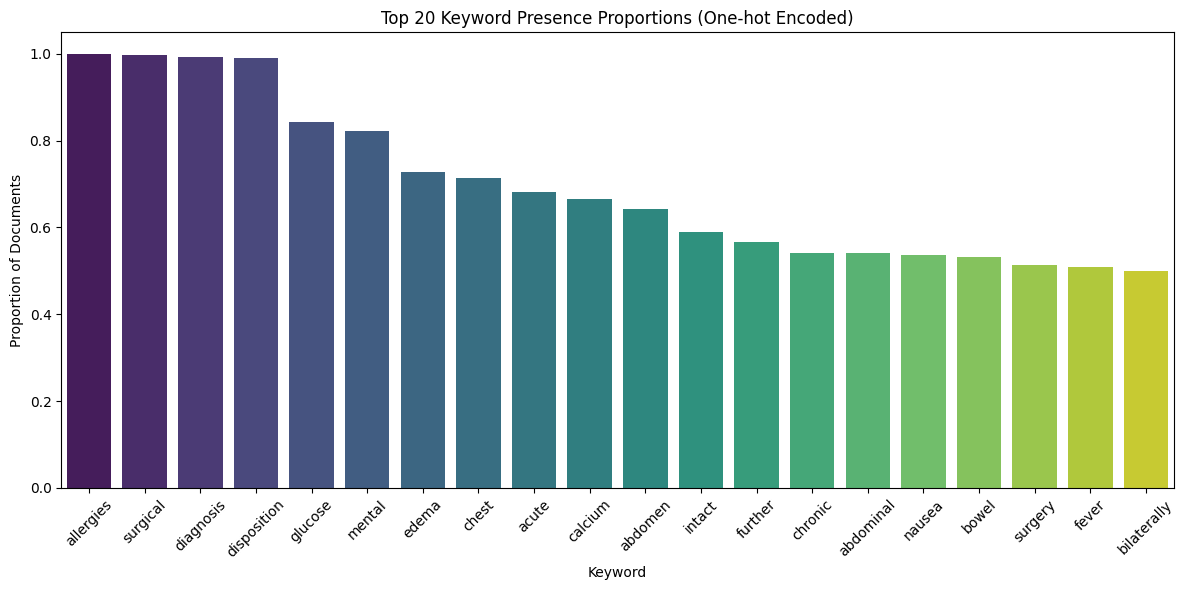

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# For final_dfOH (one-hot encoded) assume onehot_keyword_cols contains all keyword columns.
onehot_keyword_cols = final_dfOH.columns.drop("Y")

# Calculate the average presence (proportion) for each keyword.
avg_presence = final_dfOH[onehot_keyword_cols].mean().sort_values(ascending=False)

# Limit to top 20 keywords.
top_n = 20
top_keywords = avg_presence.head(top_n)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_keywords.index, y=top_keywords.values, palette="viridis")
plt.title("Top 20 Keyword Presence Proportions (One-hot Encoded)")
plt.xlabel("Keyword")
plt.ylabel("Proportion of Documents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
